# Recurant Neural Networks for Sentiment Analysis  

A Recurrent Neural Network (RNN) is a type of artificial neural network designed for sequential data processing. Unlike traditional feedforward neural networks, RNNs incorporate feedback connections that allow information to persist over time. This feature makes them well-suited for tasks involving time-series data, sequences, or data with temporal dependencies.

In [1]:
!pip install datasets
!pip install torchtext==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.0 MB/s eta 0:00:00
   

In [2]:
import collections

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import tqdm
import datasets
import torchtext

In [3]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
torch.backends.cudnn.deterministic = True

##Load the dataset

In [4]:
train_data, test_data = datasets.load_dataset('imdb', split=['train', 'test'])
train_data, test_data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

## Tokenization  
Tokenize the data using the `basic_english` tokenizer

In [5]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [6]:
def tokenize(example, max_length=200):
    tokens = tokenizer(example['text'])[:max_length]
    length = len(tokens)
    return {'tokens': tokens, 'length': length}

In [7]:
max_length = 256
train_data = train_data.map(
    tokenize, fn_kwargs={'max_length': max_length}
)
test_data = test_data.map(
    tokenize, fn_kwargs={'max_length': max_length}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [8]:
train_data, test_data

(Dataset({
     features: ['text', 'label', 'tokens', 'length'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label', 'tokens', 'length'],
     num_rows: 25000
 }))

In [9]:
train_data[0]['length'], train_data[0]['tokens'][:10]

(256,
 ['i',
  'rented',
  'i',
  'am',
  'curious-yellow',
  'from',
  'my',
  'video',
  'store',
  'because'])

## Create the vocabulary

In [10]:
min_freq = 5
specials = ['<unk>', '<pad>']

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data['tokens'],
    min_freq=min_freq,
    specials=specials,
)

In [11]:
unk_index = vocab['<unk>']
pad_index = vocab['<pad>']

unk_index, pad_index

(0, 1)

In [12]:
vocab.set_default_index(unk_index)

## Numericalize the data

In [13]:
def numericalize(example, pad_index=pad_index):
    ids = vocab.lookup_indices(example['tokens'])
    return {'ids': ids}

In [14]:
train_data = train_data.map(numericalize)
test_data = test_data.map(numericalize)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [15]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'length': Value(dtype='int64', id=None),
 'ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

## Create the Validation dataset

In [16]:
train_val_data = train_data.train_test_split(test_size=0.2)
train_data = train_val_data["train"]
val_data = train_val_data['test']

In [17]:
len(train_data), len(val_data), len(test_data)

(20000, 5000, 25000)

In [18]:
train_data = train_data.with_format('torch', columns=['ids', 'label', 'length'])
val_data = val_data.with_format('torch', columns=['ids', 'label', 'length'])
test_data = test_data.with_format('torch', columns=['ids', 'label', 'length'])

## Create the data loaders

In [19]:
def get_collete_fn(pad_index):
    def collate_fn(batch):
        ids = [x['ids'] for x in batch]
        ids = nn.utils.rnn.pad_sequence(ids, padding_value=pad_index, batch_first=True)

        labels = torch.stack([x['label'] for x in batch])
        lengths = torch.stack([x['length'] for x in batch])

        return {'ids': ids, 'length': lengths, 'labels': labels}
    return collate_fn

In [46]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collete_fn(pad_index)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn,
    )

In [47]:
batch_size = 512

train_loader = get_data_loader(train_data, batch_size, pad_index=pad_index, shuffle=True)
val_loader = get_data_loader(val_data, batch_size, pad_index=pad_index)
test_loader = get_data_loader(test_data, batch_size, pad_index=pad_index)

In [44]:
train_loader.dataset[0]

{'label': tensor(0),
 'length': tensor(256),
 'ids': tensor([   14,    10,   216,   829,     0,     9,    16,   224,    98,   125,
             3,     2,    80,   185,    10,  1596,    13,   295,    20,  1143,
           203,    44,     0,    22,    11, 11230,   219,   417,     6,   417,
             6,   341,  4598,     3,   276,   671,    99,   316,     5,  3181,
            38,  7655,    20,     2,   179,   402,    25, 15707,    24,   151,
             5,  1785,     6,  1220,   773, 16267,     3,     2,    80,   374,
            50, 18605, 13425,    32,   619,  7690,     7,     0,     6,   447,
             6,    13,     2,   342,   374,     4,   495,     5, 18594,  6949,
           105,     5, 20715,   316,   104,   151,     5,     0, 18551,     8,
             2, 18224,   129,     0,    25,    29,     2,   766,  7655,    33,
           542,     5,  3181,    38,   975,    24,   430,   104,   315,  1683,
            21,    66,  1655,   284,    25,    91,    84, 18310,    24,     3,


## Build the model

### LSTM (Long Short-Term Memory)  
LSTM is a type of Recurrent Neural Network (RNN) designed to handle long-term dependencies in sequential data. It was introduced by Sepp Hochreiter and Jürgen Schmidhuber in 1997 and has since become widely used for tasks involving time series, text, speech, and other sequential data types.  

Key Features:
- **Memory Cells**: LSTMs include memory cells that store information for long durations. This helps the network remember useful information over time, which standard RNNs struggle with due to the vanishing gradient problem.  
- **Gates**: LSTMs use three gates to control the flow of information:  
  - **Forget Gate**: Decides what information to discard from the cell state.
  - **Input Gate**: Determines what new information to add to the cell state.
  - **Output Gate**: Decides what part of the cell state to output.

In [52]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layer, pad_index, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layer,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if n_layer > 1 else 0,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [53]:
embedding_dim = 300
hidden_dim = 300
bidirectional = True
vocab_size = len(vocab)
n_layers = 2
output_dim = len(train_data.unique('label'))
dropout_rate = 0.4

model = LSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layer=n_layers,
    pad_index=pad_index,
    bidirectional=bidirectional,
    dropout=dropout_rate,
)

In [25]:
def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad == True)

print(f"Numer of parameters: {count_param(model):,}")

Numer of parameters: 11,079,902


In [26]:
def initiliaze_weight_(model):
    if isinstance(model, nn.Linear):
        nn.init.xavier_uniform_(model.weight)
        nn.init.zeros_(model.bias)
    elif isinstance(model, nn.LSTM):
        for name, param in model.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

In [27]:
model.apply(initiliaze_weight_)

LSTM(
  (embedding): Embedding(24897, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [28]:
vectors = torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [08:21, 4.34MB/s]                            
100%|█████████▉| 2196016/2196017 [05:05<00:00, 7184.20it/s]


In [54]:
pretrained_weights = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_weights.shape, pretrained_weights

(torch.Size([24897, 300]),
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
         ...,
         [ 0.6701, -0.2717,  0.4766,  ...,  0.2786,  0.3312,  0.0230],
         [-0.1503,  0.5624, -0.5622,  ..., -0.4224, -0.6836,  0.0726],
         [ 1.1741, -0.4386,  0.3310,  ...,  0.3193, -0.2292, -0.0887]]))

In [55]:
model.embedding.weight.data.shape, model.embedding.weight.data

(torch.Size([24897, 300]),
 tensor([[-0.1859,  0.3414, -0.1771,  ..., -2.1633,  0.9473, -0.1738],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.8783,  0.2409, -1.6142,  ..., -0.1909, -0.8199, -0.0565],
         ...,
         [ 0.7201,  1.0657,  1.6518,  ..., -0.4713, -0.5481, -1.1037],
         [-0.2368, -0.2299,  0.1267,  ...,  2.2991,  1.7967,  0.6508],
         [-0.4929, -0.6607, -0.8156,  ..., -1.3031,  0.1982, -0.0773]]))

In [56]:
model.embedding.weight.data = pretrained_weights

In [57]:
lr = 3e-4

optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
device

device(type='cuda')

In [60]:
model = model.to(device)
criterion = criterion.to(device)

In [61]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    prediction = prediction.argmax(dim=1)
    correct = prediction.eq(label).sum()
    return correct / batch_size

In [62]:
def train(model, optimizer, criterion):
    model.train()
    epoch_loss = []
    epoch_acc = []
    for batch in tqdm.tqdm(train_loader, desc='training...'):
        ids = batch['ids'].to(device)
        length = batch['length'].to(device)
        labels = batch['labels'].to(device)

        prediction = model(ids, length)
        loss = criterion(prediction, labels)
        acc = get_accuracy(prediction, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())

    return np.mean(epoch_loss), np.mean(epoch_acc)

In [65]:
def evaluate(model, criterion):
    model.eval()
    eval_loss = []
    eval_acc = []

    with torch.no_grad():
        for batch in tqdm.tqdm(val_loader, desc='Evaluating...'):
            ids = batch['ids'].to(device)
            length = batch['length'].to(device)
            label = batch['labels'].to(device)

            prediction = model(ids, length)
            loss = criterion(prediction, label)
            acc = get_accuracy(prediction, label)

            eval_loss.append(loss.item())
            eval_acc.append(acc.item())

    return np.mean(eval_loss), np.mean(eval_acc)

In [66]:
n_epochs = 5
metrics = collections.defaultdict(list)
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, optimizer, criterion)
    val_loss, val_acc = evaluate(model, criterion)

    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['val_loss'].append(val_loss)
    metrics['val_acc'].append(val_acc)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'model.pt')

    print("epoch: ", epoch)
    print("train loss: ", round(train_loss, 3))
    print("train acc: ", round(train_acc, 3))
    print("val loss: ", round(val_loss, 3))
    print("val acc: ", round(val_acc, 3))

Evaluating...: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch:  0
train loss:  0.476
train acc:  0.774
val loss:  0.393
val acc:  0.826


Evaluating...: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


epoch:  1
train loss:  0.394
train acc:  0.825
val loss:  0.4
val acc:  0.837


Evaluating...: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


epoch:  2
train loss:  0.353
train acc:  0.85
val loss:  0.371
val acc:  0.856


Evaluating...: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch:  3
train loss:  0.366
train acc:  0.85
val loss:  0.419
val acc:  0.841


Evaluating...: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]

epoch:  4
train loss:  0.355
train acc:  0.854
val loss:  0.339
val acc:  0.86


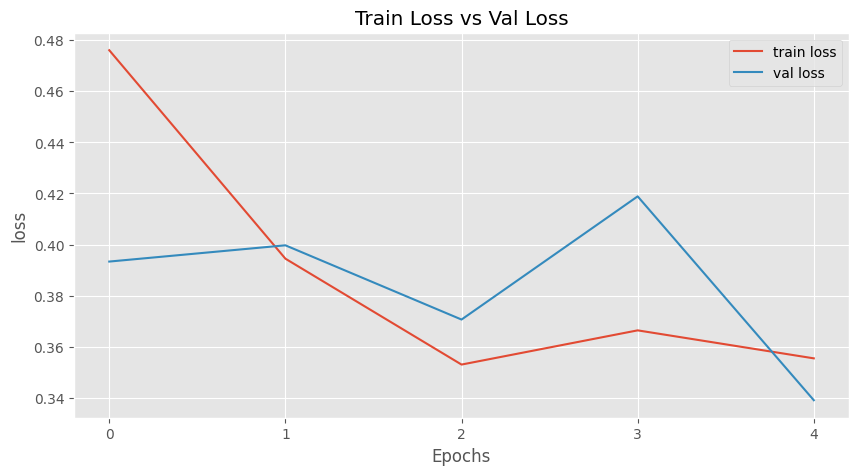

In [67]:
plt.style.use('ggplot')

plt.figure(figsize=(10, 5))
plt.plot(metrics['train_loss'], label='train loss')
plt.plot(metrics['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.xticks(range(n_epochs))
plt.title("Train Loss vs Val Loss")
plt.legend()

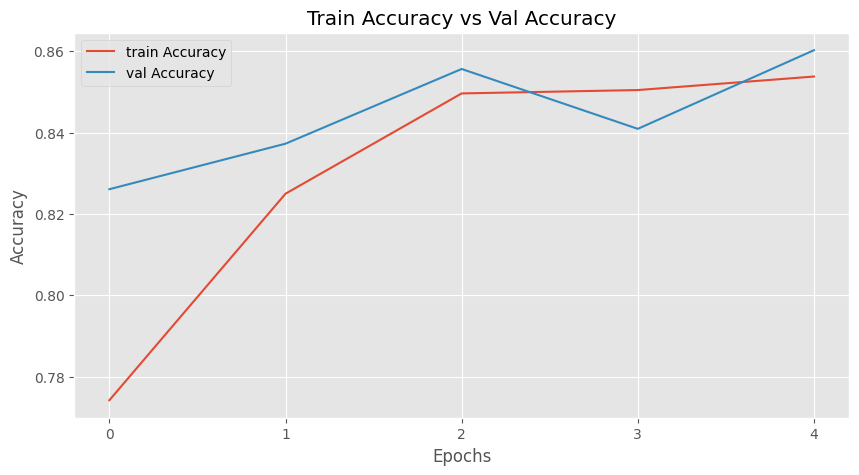

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_acc'], label='train Accuracy')
plt.plot(metrics['val_acc'], label='val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(n_epochs))
plt.title("Train Accuracy vs Val Accuracy")
plt.legend()

In [69]:
model.load_state_dict(torch.load("model.pt"))

test_loss, test_acc = evaluate(model, criterion)

Evaluating...: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


In [70]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.339, test_acc: 0.860


In [71]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [72]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.807013750076294)

In [73]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.8559097647666931)

In [74]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.5087332725524902)

In [75]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.5353025197982788)